# Energy Balance Model Practical
This practical uses a simple Energy Balance Model that is in the book by McGuffie & Henderson-Sellers. We will use it to investigate ice-albedo feedbacks and irreversibility.

The [model documentation](https://moodle.ucl.ac.uk/mod/resource/view.php?id=292610) and the [book](https://moodle.ucl.ac.uk/mod/book/view.php?id=292625) can be found on the Moodle page. But I will run through the basics here first. 



## Model Description
This model is one of the simplest around, and has been constructed in a top-down fashion (rather than the bottom-up principles used for a general circulation model). It was originally proposed by [Budyko (1969)](https://moodle.ucl.ac.uk/mod/resource/view.php?id=292627).

It divides the globe into 9 different boxes (each with an average temperature) and considers the impact of three different fluxes on each box. The boxes span from the equator to the pole, with evenly spaced boxes in the middle.     

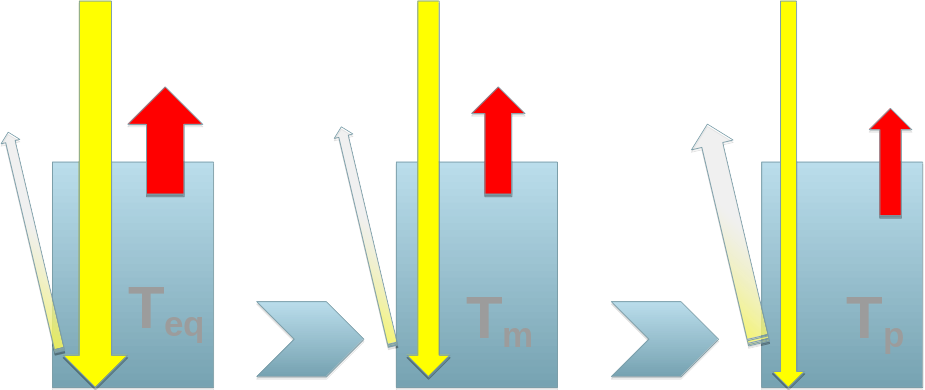

## Model Equation
The three fluxes considered by in this model are
1. The incoming solar radiation ($S_o$) of which a fraction, $\alpha$, is reflected back away from the box (yellow).
2. An outgoing longwave radiation ($L$), which depends on the temperautre of the box (red).
3. A latitudinal heat transport ($F$), which depends how warm the box is with respect to the rest of the globe (blue arrows, defined as positive when the transport is ouf to the box). 

The model is an equilibrium model (so it has no time variation in it). Therefore all the fluxes are in balance and we can write following equation for the $i$ th box.

$S_i(1-\alpha_i)=L_i+F_i$

## Parameterisations
#### Albedo
Albedo, $\alpha$, is high (0.62) if ice-covered, low if not (0.3). We shall assume a grid-box is ice-covered is if is colder than a critical temperature, $T_{crit}$.

$\alpha_i = 
  \begin{cases} 
   0.3 & \text{if } T_i > T_{crit} \\
   0.62       & \text{if } T_i \leq T_{crit}
  \end{cases}$

#### Outgoing longwave radiation
Top of atmosphere radiation is related to $\sigma$$T^4$ and the properties of atmosphere. As this model will only vary over a small range of $T$ (in Kelvin), we shall use a linear approximation:

$L_i=A+B T_i$

where $A$ and $B$ are constants derived from observations.

#### Heat transports
Heat transport is related to temperature gradients (here modelled as a form of conduction for simplicity). Having already computed the global mean temperature ($T_g$), the amount of heat transport *out* of the grid box is simply related to the a grid boxes temperature difference from the global mean.

$F=C(T_i-T_g)$

where C is a constant of proportionality, which has been derived from observational analysis.

## Numerical Approach
We shall describe how the model is programmed below, as we start coding it up. However the basic way we will solve this model is **iteratively**. What this means is that we will 
* set the model up
* feed in an initial guess
* run that guess through the equations, and see what temperatures it gives
* put those new temperatures through the equations
* repeat that process many times - moving ever slowly closer to the correct solution
* once the answer is steady, then it has **converged** on a stable answer

# Program

Start by loading the required packages into the kernal. We need *numpy* to do mathematics, *matplotlib* so that we can visualise the output, and then *pandas*: the [Python Data Analysis Library](https://pandas.pydata.org/) to build a data frame to store the model output with some metadata.   

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Define some tunable parameters (we shall be altering these later in the exercise)

In [2]:
#Input quantities
FracSC=1    #solar constant as fraction of present day 
A=204       #thermal A
B=2.17      #thermal B
C=3.81      #transport C
t_crit=-10  #critical temp

Specify some important constants, and set up some essential factors related to the grid boxes. Each grid box is defined by its mean latitude, which helps specify the proportion of incoming solar radiation it receives, `SunWt`, and how much it contributes to the global average temperature, `cos_lat`.

In [3]:
#constant para. and names
SC=1370 #solar constant of present day in W/m^2
a=0.3   #albedo without ice
a_ice=0.62  #ice albedo
zones=['80-90','70-80','60-70','50-60','40-50','30-40','20-30','10-20','0-10'] #znoal bands
zones_mean=np.array([85,75,65,55,45,35,25,15,6]) #mean lat. of each zonal band
SunWt=np.array([0.5,0.531,0.624,0.77,0.892,1.021,1.12,1.189,1.219])
cos_lat=np.cos(zones_mean*3.1415/180)
R_in=SC/4*FracSC*SunWt #compute the incoming solar radiation at each latitude

We need to specify our initial temperatures. These then allow us to determine the albedo at each latitude

In [4]:
#initial condition
init_t=[-15,-15,-5,5,10,15,18,22,24] #initial temp
init_a=np.zeros(len(init_t)) #create an array to store initial albedo
for i in range(len(zones)):
    if init_t[i]<t_crit:
        init_a[i]=a_ice
    else:
        init_a[i]=a


Run these initial temperatures through the equation set to see what it does... 

In [5]:
#Step 1
Tcos=init_t*cos_lat
mean_T=np.sum(Tcos)/np.sum(cos_lat)
Temp=(R_in*(1-init_a)+C*mean_T-A)/(B+C)
albedo=np.zeros(len(zones)) #create an array to store initial albedo
for i in range(len(zones)): 
    if Temp[i]<t_crit:
        albedo[i]=a_ice
    else:
        albedo[i]=a

Now that we've done it once, let's iterate it again many times (25 here) to allow it to converge.

In [6]:
#following steps
step_no=25 #stop number
for i in range(step_no):
    Tcos=Temp*cos_lat
    mean_T=np.sum(Tcos)/np.sum(cos_lat)
    Temp=(R_in*(1-albedo)+C*mean_T-A)/(B+C)
    albedo=np.zeros(len(zones)) #create an array to store initial albedo
    for i in range(len(zones)):
        if Temp[i]<t_crit:
            albedo[i]=a_ice
        else:
            albedo[i]=a
print("Running the model results in a global mean temperature of % 5.2f oC." %mean_T) 

Running the model results in a global mean temperature of  14.77 oC.


So far everything is stored as separate vectors. It would be much more useful to store things in a structure that can also have some metadata (information about the data). We are going to use a DataFrame, which is provided by `pandas`. 

In [7]:
pd.DataFrame({'zones':zones,'Albedo':albedo,'Temp':Temp})

,zones,Albedo,Temp
0,80-90,0.62,-13.823407
1,70-80,0.62,-13.148717
2,60-70,0.30,0.311877
3,50-60,0.30,6.165305
4,40-50,0.30,11.056526
5,30-40,0.30,16.228390
6,20-30,0.30,20.197496
7,10-20,0.30,22.963842
8,0-10,0.30,24.166601


Finally let us plot the output. Which we are going to do using the routines in `matplotlib`.

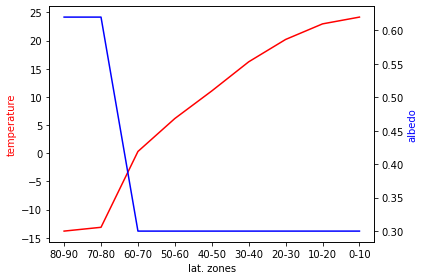

In [8]:
#plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('lat. zones')
ax1.set_ylabel('temperature',color='r')
ax1.plot(zones, Temp,'r' )
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # create a second axes that shares the same x-axis


ax2.set_ylabel('albedo',color='b')  
ax2.plot(zones, albedo,'b')
ax2.tick_params(axis='y')


fig.tight_layout()  

plt.show()

# Exercise and investigations with the model

Having build a program of this model, we now need to use it learn something about the climate system. I want you to answer five different questions:
1. What fractional decrease of the solar constant is required to glaciate the world (i.e. make a snowball Earth)?
2. What would be the impact of increasing $C$, the heat transport parameter?  Write down a hypothesis first.
3. The critical temperatures over land and sea are different ($0 ^oC$ and $-13 ^oC$), yet this model just represents a single hemisphere. Do you expect the Arctic or Antarctic to be colder? Test this by altering $T_{crit}$
4. Early estimates for $B$ ranged from 1.45 to 1.6, but how does the higher value of $B$ used here influence the climate? What does it correspond to physically?
5. If you set the initial temperatures to those of a snowball Earth, what fraction of solar constant is required to remove the ice from the Equator. What does this mean for the climate?


All of these questions can be investigated by altering the "tunable parameters" and the initial temperatures. Below we have gathered these together in a single cell, followed by a single cell for you to run and plot the output (which you should not edit). 

In [ ]:
#Edit these values
FracSC=1.0    #solar constant as fraction of present day 
A=204       #thermal A
B=2.17      #thermal B
C=3.81      #transport C
t_crit=-10.  #critical temp
init_t=[-15.,-15.,-5.,5.,10.,15.,18.,22.,24.] #initial temp

In [ ]:
SC=1370 #solar constant of present day in W/m^2
a=0.3   #albedo without ice
a_ice=0.62  #ice albedo
zones=['80-90','70-80','60-70','50-60','40-50','30-40','20-30','10-20','0-10'] #znoal bands
zones_mean=np.array([85,75,65,55,45,35,25,15,6]) #mean lat. of each zonal band
SunWt=np.array([0.5,0.531,0.624,0.77,0.892,1.021,1.12,1.189,1.219])
cos_lat=np.cos(zones_mean*3.1415/180)
R_in=SC/4*FracSC*SunWt #compute the incoming solar radiation at each latitude
init_a=np.zeros(len(init_t)) #create an array to store initial albedo
for i in range(len(zones)):
    if init_t[i]<t_crit:
        init_a[i]=a_ice
    else:
        init_a[i]=a

#Step 1
Tcos=init_t*cos_lat
mean_T=np.sum(Tcos)/np.sum(cos_lat)
Temp=(R_in*(1-init_a)+C*mean_T-A)/(B+C)
albedo=np.zeros(len(zones)) #create an array to store initial albedo
for i in range(len(zones)): 
    if Temp[i]<t_crit:
        albedo[i]=a_ice
    else:
        albedo[i]=a

        #following steps
step_no=25 #stop number
for i in range(step_no):
    Tcos=Temp*cos_lat
    mean_T=np.sum(Tcos)/np.sum(cos_lat)
    Temp=(R_in*(1-albedo)+C*mean_T-A)/(B+C)
    albedo=np.zeros(len(zones)) #create an array to store initial albedo
    for i in range(len(zones)):
        if Temp[i]<t_crit:
            albedo[i]=a_ice
        else:
            albedo[i]=a
print("Running the model results in a global mean temperature of % 5.2f oC." %mean_T)           
pd.DataFrame({'zones':zones,'Albedo':albedo,'Temp':Temp})
#plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('lat. zones')
ax1.set_ylabel('temperature',color='r')
ax1.plot(zones, Temp,'r' )
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # create a second axes that shares the same x-axis
ax2.set_ylabel('albedo',color='b')  
ax2.plot(zones, albedo,'b')
ax2.tick_params(axis='y')
fig.tight_layout()  
plt.show()